In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import statsmodels.api as sm
plt.style.use('ggplot')

# Problem 2

## 2 (a)

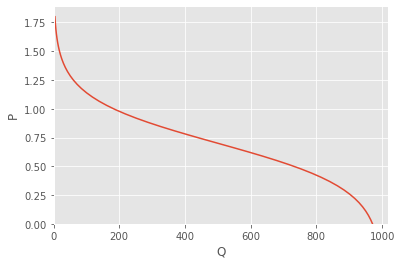

In [5]:
Tb= 2.5
Tc = 1.5
Mc = 2

def P(Mb):
    Vsb =  -4*Tb - 5*Mb
    Vsc = 1-3*Tc - 5*Mc
    return np.exp(Vsb)/(np.exp(Vsb)+np.exp(Vsc))*1e3
Mbs = np.linspace(0,1.8,50)
Ps = P(Mbs)
plt.plot(Ps,Mbs) #note here I dont get the inverse function, I just created a range of prices and I plot that as the x axis 
plt.xlabel("Q")
plt.ylabel("P")
plt.ylim(0,plt.ylim()[1]) #plt.ylim() called without arguments returns the limits, so take the second one to get the upper limit
plt.xlim(0,plt.xlim()[1])
plt.savefig("./hw3-2.pdf") # this saves the file as a pdf

##  2 (b)

In [6]:
res = opt.minimize_scalar(lambda Mb: -P(Mb)*Mb,bounds=(0,np.inf))
print("The revenue is {:.2f}, ridership is {:.2f} and optimal price is {:.2f}.".format(-res.fun, -res.fun/res.x,res.x))

The revenue is 374.53, ridership is 651.89 and optimal price is 0.57.


# Problem 3

# 3 a(i)

In [14]:
data = pd.read_csv("logit_truck_rail.csv",index_col="route_index") #i use the index_col keyword argument to tell pandas  to use the route_index as an index
# exogenous data for logit
exog = data.drop('P_actual',axis=1) # i can use .drop to drop the P_actual from it. check documentation https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html 
exog = sm.add_constant(exog) # add the one column
mod = sm.Logit(data.P_actual,exog)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.387862
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               P_actual   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1995
Method:                           MLE   Df Model:                            4
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                  0.3688
Time:                        17:11:04   Log-Likelihood:                -775.72
converged:                       True   LL-Null:                       -1229.0
Covariance Type:            nonrobust   LLR p-value:                6.321e-195
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5023      0.520     -0.967      0.334      -1.521       0.516
t_rail        -2.9606      0.188    -15.767      0.000      -3.329      -2.593
t_truck        2.9542      0.203     14.523      0.000       2.556       3.353
c_rail        -1.4419      0.232     -6.206      0.000      -1.897      -0.987
c_truck        1.4622      0.117     12.454      0.000       1.232       1.692
==============================================================================
"""

In [17]:
αrail = res.params.const
βTrail = res.params.t_rail
βCrail = res.params.c_rail
βTtruck = -res.params.t_truck
βCtruck = -res.params.c_truck
# i can use a new line symbol \n to force line breaks
string = "αrail = {:.2f} \n βT,rail = {:.2f} \n βT,truck = {:.2f} \n  βC,rail = {:.2f} \n βC,truck = {:.2f}"
print(string.format(αrail,βTrail,βTtruck,βCrail,βCtruck))

αrail = -0.50 
 βT,rail = -2.96 
 βT,truck = -2.95 
  βC,rail = -1.44 
 βC,truck = -1.46


# 3 a(ii)

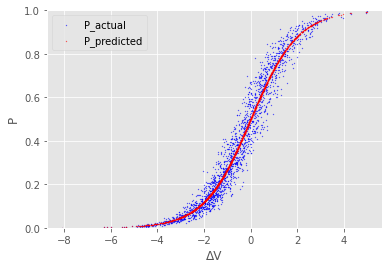

In [20]:
ΔV = exog.dot(res.params)
# here is another way to do what I showed you in class
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.scatter(ΔV,data.P_actual,s=.8,alpha=0.5,color='blue',label="P_actual")
ax.scatter(ΔV,res.predict(),color='red',s=.8,alpha=0.5,label="P_predicted")
ax.set_xlabel('ΔV') 
ax.set_ylabel('P') 
ax.set_ylim([0,1])
ax.legend()
# fig.savefig("./hw3-3aii.pdf")


# 3(b)(ii)

In [24]:
projects = pd.read_csv("./investmentOpportunities.csv",index_col='route_index')

def profit(c_rail,row): #note here I do not redefine any variables to the row
    V_rail = αrail + βTrail*row.t_rail + βCrail*c_rail
    V_truck = βTtruck*row.t_truck + βCtruck*row.c_truck
    return (row.market_size*np.exp(V_rail)/(np.exp(V_rail)+np.exp(V_truck))*(c_rail-row.marginal_cost) - row.fixed_cost)

def g(row):
    res= opt.minimize_scalar(lambda c_rail: -profit(c_rail,row),bracket=(0,10),method='brent')
    return [res.x,-res.fun]

# no for loop
projects[['c_rail','profit']] = projects.apply(g,result_type='expand',axis=1) #add two new columns to the data frame
projects

,t_truck,t_rail,c_truck,market_size,fixed_cost,marginal_cost,c_rail,profit
route_index,,,,,,,,
0,1.397970,1.802601,1.471928,8.999524,3.231222,0.202073,1.112730,-1.277079
1,1.693280,1.611896,1.529285,7.809950,2.276808,0.251122,1.507238,2.117055
2,1.308932,1.819581,1.640829,7.786981,2.735189,0.188427,1.091472,-1.103607
3,1.430880,2.092944,1.677400,7.072724,2.764367,0.203187,1.047100,-1.700666
4,1.387206,2.068974,1.578171,5.806251,1.946992,0.169054,0.994910,-1.178604
5,1.671288,1.701612,1.388799,9.048791,3.286355,0.114085,1.270615,0.903345
6,1.357479,1.865834,1.952818,6.844087,2.691690,0.116538,1.126476,-0.526091
7,1.763820,1.889876,2.007610,7.083875,2.293089,0.186288,1.499284,2.095212
8,1.220934,1.829205,1.433709,7.470130,2.727808,0.104489,0.941916,-1.652790


In [26]:
# I can filter the functions with positive profit like this
projects[projects.profit>0]

,t_truck,t_rail,c_truck,market_size,fixed_cost,marginal_cost,c_rail,profit
route_index,,,,,,,,
1,1.693280,1.611896,1.529285,7.809950,2.276808,0.251122,1.507238,2.117055
5,1.671288,1.701612,1.388799,9.048791,3.286355,0.114085,1.270615,0.903345
7,1.763820,1.889876,2.007610,7.083875,2.293089,0.186288,1.499284,2.095212
9,1.778424,1.683518,1.529780,4.559574,1.892559,0.144563,1.462656,0.955235


In [27]:
print("The profitable ones are 1, 5, 7 and 9.")

The profitable ones are 1, 5, 7 and 9.
